In [3]:
%run "..\..\..\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"..\..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

29604


In [4]:
import cv2

In [6]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 295


In [7]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

ModuleNotFoundError: No module named 'numba'

In [9]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

ModuleNotFoundError: No module named 'dotenv'

In [8]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
        
    print(f"- seg file: {seg_save_file}")

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_488 = _cls.im_488[0::4]
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750,405], corr_chromatic=False)
    break
    
    
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
        test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in polyt_im])

        seg_model = models.CellposeModel(gpu=True, model_type='TN2')

        labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                        batch_size=60, anisotropy=1000/108/2,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        #diameter=25, 
                                        min_size=100,
                                        do_3D=True,
                                        )

        print(f"in {time.time()-_cellpose_start:.3f}s.")
        # resize segmentation label back
        corr_labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                        interpolation=cv2.INTER_NEAREST_EXACT) 
                             for _ly in labels3d])
        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

    # Prepare watershed
    print(f"- run watershed")
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    

NameError: name 'watershed_folder' is not defined

## Check result

<IPython.core.display.Javascript object>


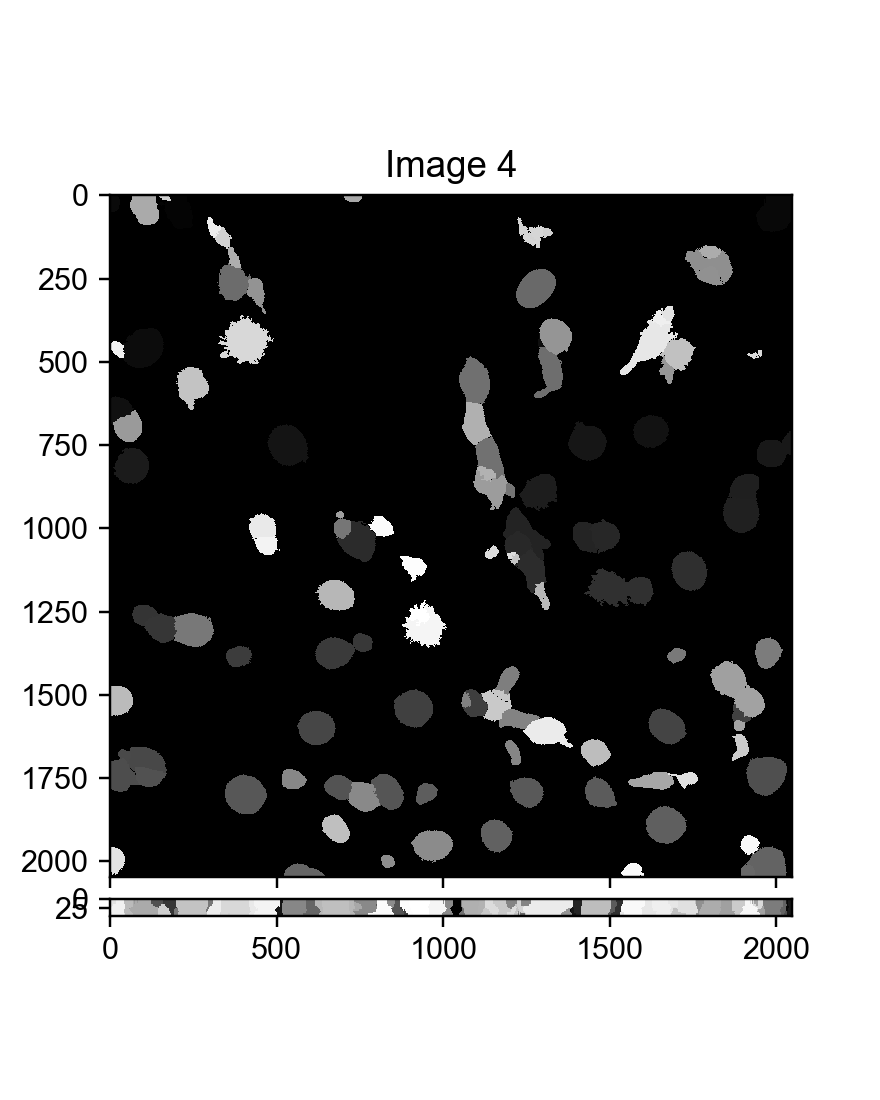

In [12]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])

# check merlin outputs

In [14]:
import h5py

In [66]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG_test\CellPoseSegment\features\feature_data_0.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


<IPython.core.display.Javascript object>


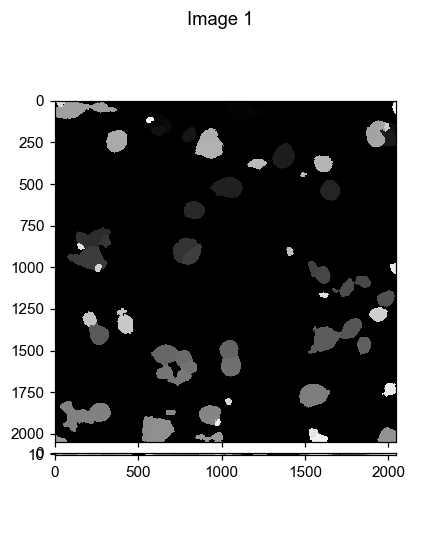

In [67]:
visual_tools.imshow_mark_3d_v2([watershed_labels])

In [8]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG\CellPoseSegment\features\feature_data_80.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    new_watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


In [46]:
from skimage import segmentation

new_labels = segmentation.watershed(
                waterIm, old_label3d, mask=waterMask,
                connectivity=np.ones((3, 3, 3)), watershed_line=True)

<IPython.core.display.Javascript object>


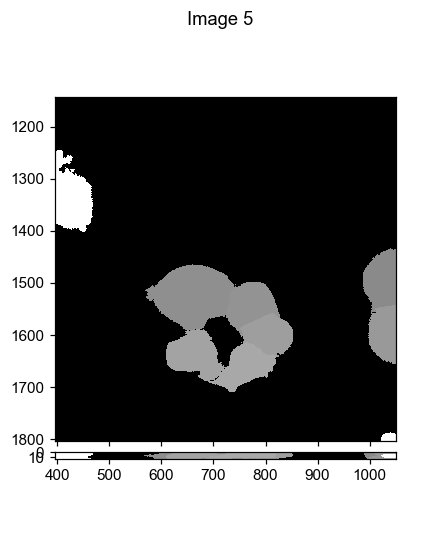

In [47]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask, old_label3d, new_labels])

In [71]:
relabel_info = pickle.load(open(r'E:\Processed_Data_Backup\202003_IMR90_chr2_repeat_relabelling\picked_relabeled_spot_pairs_2-71.pkl','rb'))

In [ ]:
visual_tools

In [85]:
relabe_zxys

array([[[2.44868031e+03, 4.69997054e+03, 7.23436359e+03, 7.48437071e+00],
        [3.73104439e+03, 4.62864729e+03, 7.40921924e+03, 2.39197063e+00],
        [2.24792957e+03, 4.69036958e+03, 7.14845435e+03, 1.58881152e+00],
        ...,
        [2.64051418e+03, 3.11798666e+03, 6.11022821e+03, 9.19883347e+00],
        [2.63617077e+03, 3.07044704e+03, 6.22241441e+03, 7.41383934e+00],
        [2.26103153e+03, 3.21625182e+03, 6.25290601e+03, 3.86180091e+00]],

       [[2.16445065e+03, 3.13107282e+03, 1.01894727e+04, 8.00683212e+00],
        [3.10189037e+03, 4.85165479e+03, 1.02543698e+04, 5.19267321e+00],
        [2.81243649e+03, 4.97361086e+03, 1.03899894e+04, 2.71444392e+00],
        ...,
        [2.79996834e+03, 3.67189906e+03, 1.06949391e+04, 2.33186173e+00],
        [2.76656399e+03, 3.55870226e+03, 1.10467400e+04, 4.68488646e+00],
        [2.73376083e+03, 3.81614900e+03, 1.05940896e+04, 1.11110854e+00]],

       [[2.97902107e+03, 1.35271961e+04, 9.24907709e+03, 2.12193418e+00],
        

In [83]:
relabe_zxys = np.load(r'\\10.245.74.158\Chromatin_NAS_4\2020_cell_materials\Chromatin_Share\Repicked_chromosome_data\before_20200512\zxyhs_final_EM_chr21_relabel.npy')

In [82]:
relabel_info['old'][1][0]

array([[ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.88830070e+01,  2.29775448e+01,  1.74338776e+02, ...,
        -6.78960886e-03, -6.34057760e-01,  5.79653076e+02],
       ...,
       [ 2.60387554e+01,  2.41951199e+01,  1.68056412e+02, ...,
         1.13709886e-02,  8.33605453e-02,  6.47226807e+02],
       [ 4.13785648e+00,  2.30000000e+01,  1.66000000e+02, ...,
         2.44903816e-07,  4.09684958e-07,  4.69725189e+02],
       [ 1.32260017e+01,  2.31380005e+01,  1.71030380e+02, ...,
         4.81985718e-01, -4.74240720e-01,  3.35760864e+02]])

In [79]:
len(relabel_info['old'][1][0])

357

In [78]:
len(relabel_info['new'][0][0])

357

In [46]:
!dir ..\..\S

 Volume in drive E is Data_01
 Volume Serial Number is B8F1-585C

 Directory of E:\Users\puzheng\Documents

05/28/2022  01:00 AM    <DIR>          .
05/28/2022  01:00 AM    <DIR>          ..
10/20/2020  12:30 AM    <DIR>          Chromatin_Analysis_2020_cell
05/26/2022  04:03 PM    <DIR>          Chromatin_Analysis_Scripts
10/20/2020  12:23 AM    <DIR>          Codes
05/26/2022  04:55 PM    <DIR>          ConvNeXt
10/20/2020  12:23 AM    <DIR>          Custom Office Templates
12/18/2020  10:12 PM             1,276 debug.log
10/20/2020  12:23 AM    <DIR>          dna-analysis
10/20/2020  12:23 AM    <DIR>          Hi-C
05/26/2022  03:09 PM    <DIR>          ImageAnalysis3
05/28/2022  01:00 AM    <DIR>          Insight3
05/27/2022  12:55 PM    <DIR>          Merfish_Analysis_Scripts
05/27/2022  12:55 PM    <DIR>          MERlin
05/26/2022  03:40 PM    <DIR>          OneNote Notebooks
05/26/2022  02:37 PM    <DIR>          Python Scripts
10/20/2020  12:23 AM    <DIR>          rdpwrap
09/3